In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, RFE, f_classif
from sklearn.model_selection import train_test_split,  GridSearchCV, KFold
from sklearn.ensemble import   RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Lasso, LassoCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

In [14]:
#Import data frame
serie_a = pd.read_csv('Serie_a.csv')

In [15]:
#Removing Variables
serie_a = serie_a.drop(columns= ['Div','FTHG','FTAG','HTHG', 'HTAG', 'HTR', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC',
       'HY', 'AY', 'HR', 'AR','Attendance','HomeTeamPoints', 'AwayTeamPoints'],axis=1)

In [16]:
#Encode all variables that are numerical 
#Make all variables int or float
encoder = LabelEncoder()
serie_a['FTR']=encoder.fit_transform(serie_a['FTR'])
serie_a['HomeTeam']=encoder.fit_transform(serie_a['HomeTeam'])
serie_a['AwayTeam']=encoder.fit_transform(serie_a['AwayTeam'])

#remove / from date
serie_a['Date'] = serie_a['Date'].str.replace('/', '')
# Extract the first two digits of the year for 'ddmmyyyy' format
serie_a['Date'] = serie_a['Date'].apply(lambda x: x[:-4] + x[-2:] if len(x) == 8 else x)
# date to float 
serie_a['Date'] = serie_a['Date'].astype(int)

#remove / from season
serie_a['Season'] = serie_a['Season'].str.replace('/','')
#extract the end 2 values of each year
serie_a['Season'] = serie_a['Season'].apply(lambda x: x[2] + x[3] + x[6] + x[7])
#convert to integer 
serie_a['Season'] = serie_a['Season'].astype(int)

serie_a['PreCovid'] = serie_a['PreCovid'].astype(int)

In [17]:
#Check data types
serie_a.dtypes

Season             int32
Date               int32
HomeTeam           int32
AwayTeam           int32
FTR                int32
HAGSFT           float64
AAGSFT           float64
HAGSHT           float64
AAGSHT           float64
HAGCFT           float64
AAGCFT           float64
HAR              float64
AAR              float64
HAY              float64
AAY              float64
HAF              float64
AAF              float64
HAC              float64
AAC              float64
HAS              float64
AAS              float64
HAST             float64
AAST             float64
HAWH             float64
HALH             float64
HADH             float64
AAWA             float64
AALA             float64
AADA             float64
PreCovid           int32
OverallHA        float64
SeasonalHA       float64
HAPreCovid       float64
HADuringCovid    float64
dtype: object

In [18]:
#splitting into X and y
X = serie_a.drop('FTR', axis=1)
y = serie_a['FTR']

In [19]:
#Splitting the test and train data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=380, shuffle =False)

In [20]:
#Scale variables 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Correlation

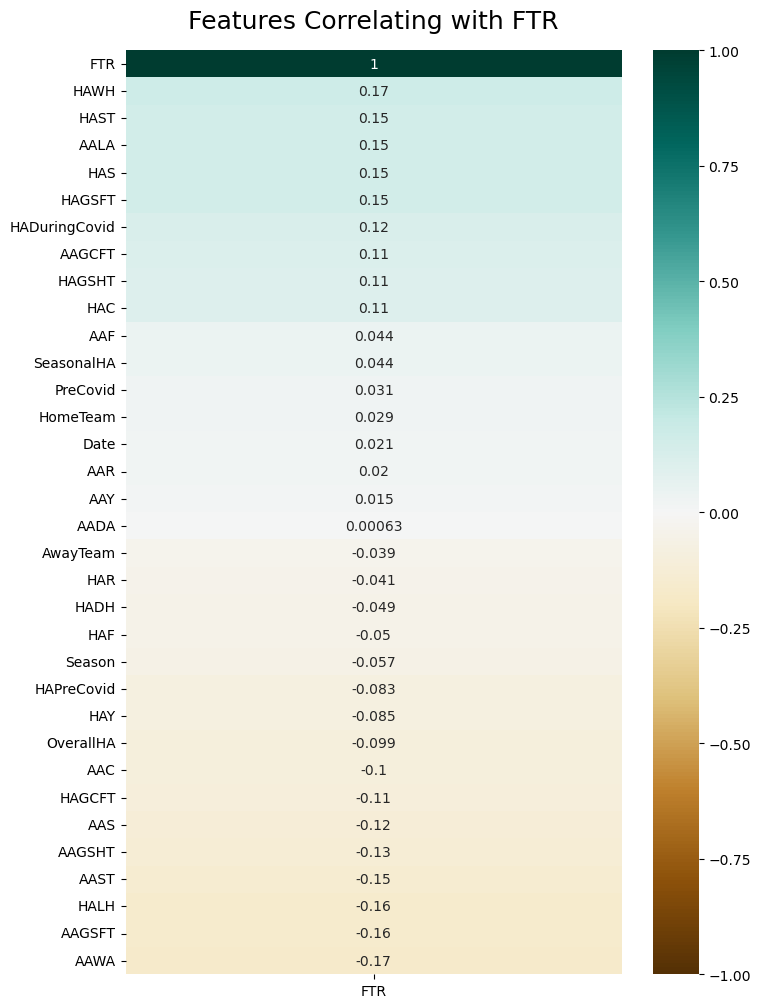

In [21]:
#Correlation with FTR 
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(serie_a.corr()[['FTR']].sort_values(by='FTR', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with FTR', fontdict={'fontsize':18}, pad=16);

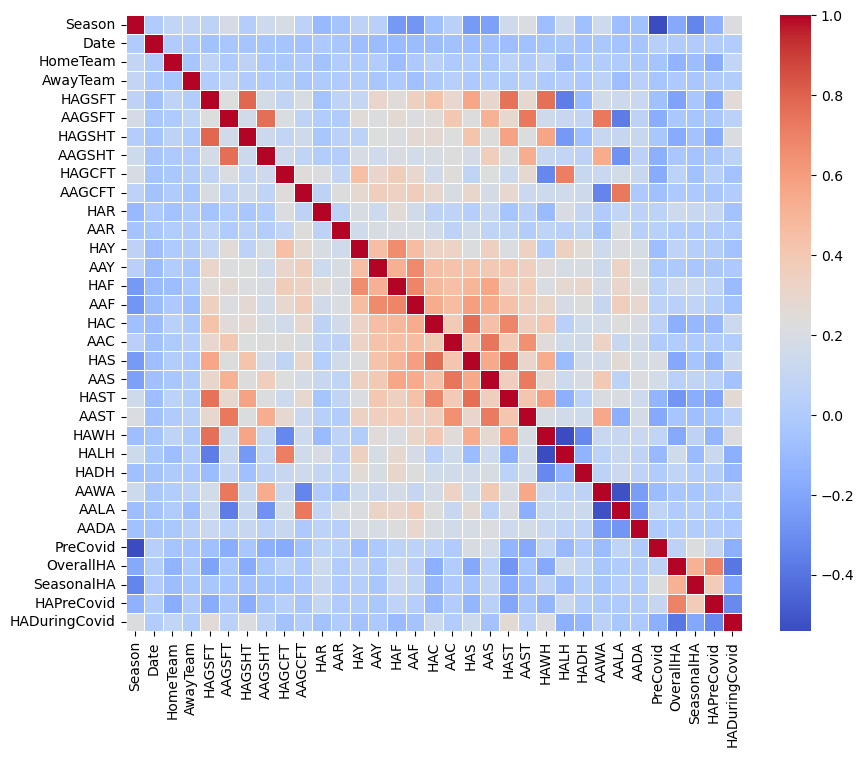

In [22]:
#Correlation heat map
correlation_matrix = X.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', linewidths=.5, square=True,
            xticklabels=correlation_matrix.columns, yticklabels=correlation_matrix.columns)

plt.show()

In [23]:
# Find pairs of variables with correlation above 0.75
high_corr_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.75:
            colname_i = correlation_matrix.columns[i]
            colname_j = correlation_matrix.columns[j]
            correlation_coefficient = correlation_matrix.iloc[i, j]
            high_corr_pairs.append((colname_i, colname_j, correlation_coefficient))

# Print the pairs of variables and their correlation coefficients above 0.75
print("Pairs of variables with correlation above 0.75:")
for pair in high_corr_pairs:
    print(f"{pair[0]} and {pair[1]}: {pair[2]:.2f}")

Pairs of variables with correlation above 0.75:
HAGSHT and HAGSFT: 0.78
AAGSHT and AAGSFT: 0.76
HAS and HAC: 0.77
HAST and HAGSFT: 0.75
HAST and HAS: 0.76
HAWH and HAGSFT: 0.76


In [24]:
#features with high correlation removed 
serie_a = serie_a.drop(columns=['HAGSFT','AAGSHT','HAS'])


In [25]:
#Recreating the test and train now the correlated variables have been removed
X=serie_a.drop('FTR',axis=1)
y=serie_a['FTR']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=380, shuffle =False)
#Scale variables 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Filter Method

In [26]:

# Use SelectKBest with ANOVA F-statistic to select the top k features

selector = SelectKBest(f_classif, k=5) #k=5 is the number of features to select
X_train_selected = selector.fit_transform(X, y)

# Get the indices of the selected features
selected_feature_indices = selector.get_support(indices=True)

# Display the selected features
selected_features = X.columns[selected_feature_indices]
print(f"Top 5 Selected Features:")
print(selected_features)

Top 5 Selected Features:
Index(['AAGSFT', 'HAWH', 'HALH', 'AAWA', 'AALA'], dtype='object')


#  LASSO

In [27]:
# Initialise the LassoCV model with a range of alpha values
alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
lasso_cv_model = LassoCV(alphas=alphas, cv=5)  # 5-fold cross-validation

# Train the LassoCV model
lasso_cv_model.fit(X_train, y_train)

# Find the optimal alpha
optimal_alpha = lasso_cv_model.alpha_
print(f"Optimal alpha: {optimal_alpha}")

# Make predictions
y_pred = lasso_cv_model.predict(X_test)

# Evaluate the model
print("Lasso Regression Results:")
print("Accuracy:", accuracy_score(y_test, y_pred.round()))
print("Classification Report:\n", classification_report(y_test, y_pred.round()))

Optimal alpha: 0.01
Lasso Regression Results:
Accuracy: 0.2894736842105263
Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.02      0.04       128
           1       0.25      0.89      0.39        97
           2       0.62      0.14      0.22       155

    accuracy                           0.29       380
   macro avg       0.43      0.35      0.22       380
weighted avg       0.46      0.29      0.21       380



In [28]:
# Initialise the Lasso model with the optimal alpha
lasso_model = Lasso(alpha=optimal_alpha)

# Train the Lasso model
lasso_model.fit(X_train, y_train)

# Get the coefficients and corresponding feature names
coefficients = lasso_model.coef_
feature_names = X.columns  # Assuming X is a pandas DataFrame

# Create a dictionary mapping feature names to their absolute coefficients
feature_coefficients = dict(zip(feature_names, abs(coefficients)))

# Sort the features based on their absolute coefficients in descending order
sorted_features = sorted(feature_coefficients.items(), key=lambda x: x[1], reverse=True)

# Select the top 5 features
top_5_features = [feature for feature, _ in sorted_features[:5]]

print("Top 5 Features selected by Lasso:")
print(top_5_features)

Top 5 Features selected by Lasso:
['HAST', 'AAS', 'AAGCFT', 'AAGSFT', 'SeasonalHA']


#  RFE

Selected Features: Index(['Date', 'AAS', 'HAST', 'AAST', 'SeasonalHA'], dtype='object')


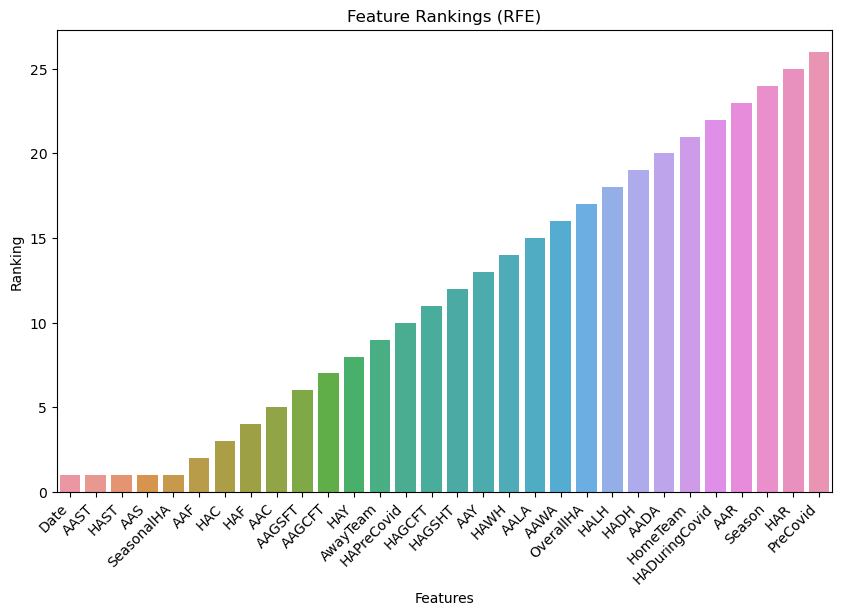

In [29]:
#Random Forest

# Initialise the model for RFE
model_rfe = RandomForestClassifier()

# Choose the number of features to select
num_features_to_select = 5

# Perform RFE
rfe = RFE(model_rfe, n_features_to_select=num_features_to_select)
X_train_rfe = rfe.fit_transform(X_train, y_train)

# Display selected features
X_columns = X.columns 

selected_features = X_columns[rfe.support_]
print("Selected Features:", selected_features)

# Plot feature rankings
feature_ranking = pd.Series(rfe.ranking_, index=X_columns)
feature_ranking_sorted = feature_ranking.sort_values(ascending=True)
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_ranking_sorted.index, y=feature_ranking_sorted.values)
plt.title("Feature Rankings (RFE)")
plt.xlabel("Features")
plt.ylabel("Ranking")
plt.xticks(rotation=45, ha="right")
plt.show()

# Classification

In [30]:
#Implementing the feature analysis  

X=serie_a.drop('FTR', axis=1)
y= serie_a['FTR']
X = X[['AAGSFT', 'HAST', 'AAS', 'HAWH', 'SeasonalHA']]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=380, shuffle =False)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Logistic Regression

In [31]:
log = LogisticRegression(max_iter=100000)

model_log = log.fit(X_train, y_train)

pred_log = model_log.predict(X_test)

accuray = accuracy_score(y_test, pred_log)
precision = precision_score(y_test, pred_log, average='weighted')
recall = recall_score(y_test, pred_log, average='weighted')
f1 = f1_score(y_test, pred_log, average='weighted')

print("The classification report of Logistic Regression classification: \n",classification_report(y_test, pred_log))


print("From the class report we can see that the classification has precision of {}%, with a recall of {}%, an f1-score of {}.".format(round(precision*100,2), round(recall*100, 2), f1))
print("The accuracy of the model is {}%".format(round(accuray*100,2)))

The classification report of Logistic Regression classification: 
               precision    recall  f1-score   support

           0       0.55      0.50      0.52       128
           1       0.00      0.00      0.00        97
           2       0.50      0.85      0.63       155

    accuracy                           0.52       380
   macro avg       0.35      0.45      0.38       380
weighted avg       0.39      0.52      0.43       380

From the class report we can see that the classification has precision of 38.98%, with a recall of 51.58%, an f1-score of 0.4337069443043031.
The accuracy of the model is 51.58%


## Decison Tree 

In [32]:
# Set a seed for reproducibility
seed_value = 42
np.random.seed(seed_value)

dt = DecisionTreeClassifier()

model_dt = dt.fit(X_train,y_train)

pred_dt = model_dt.predict(X_test)

accuray = accuracy_score(y_test, pred_dt)
precision = precision_score(y_test, pred_dt, average='weighted')
recall = recall_score(y_test, pred_dt, average='weighted')
f1 = f1_score(y_test, pred_dt, average='weighted')

print("The classification report of Decision Tree classification: \n",classification_report(y_test, pred_dt))


print("From the class report we can see that the classification has precision of {}%, with a recall of {}%, an f1-score of {}.".format(round(precision*100,2), round(recall*100, 2), f1))
print("The accuracy of the model is {}%".format(round(accuray*100,2)))

The classification report of Decision Tree classification: 
               precision    recall  f1-score   support

           0       0.38      0.33      0.35       128
           1       0.31      0.37      0.34        97
           2       0.44      0.44      0.44       155

    accuracy                           0.38       380
   macro avg       0.38      0.38      0.38       380
weighted avg       0.39      0.38      0.38       380

From the class report we can see that the classification has precision of 38.8%, with a recall of 38.42%, an f1-score of 0.38478352245965636.
The accuracy of the model is 38.42%


## Naive Bayes

In [33]:
nb = GaussianNB()

model_nb = nb.fit(X_train,y_train)

pred_nb = model_nb.predict(X_test)

accuray = accuracy_score(y_test, pred_nb)
precision = precision_score(y_test, pred_nb, average='weighted')
recall = recall_score(y_test, pred_nb, average='weighted')
f1 = f1_score(y_test, pred_nb, average='weighted')

print("The classification report of Naive Bayes classification: \n",classification_report(y_test, pred_nb))


print("From the class report we can see that the classification has precision of {}%, with a recall of {}%, an f1-score of {}.".format(round(precision*100,2), round(recall*100, 2), f1))
print("The accuracy of the model is {}%".format(round(accuray*100,2)))

The classification report of Naive Bayes classification: 
               precision    recall  f1-score   support

           0       0.56      0.60      0.58       128
           1       0.00      0.00      0.00        97
           2       0.52      0.81      0.63       155

    accuracy                           0.53       380
   macro avg       0.36      0.47      0.41       380
weighted avg       0.40      0.53      0.45       380

From the class report we can see that the classification has precision of 40.17%, with a recall of 53.42%, an f1-score of 0.4546653025796753.
The accuracy of the model is 53.42%


## SVM

In [34]:
svm = SVC()

model_svc = svm.fit(X_train,y_train)

pred_svc = model_svc.predict(X_test)

accuray = accuracy_score(y_test, pred_svc)
precision = precision_score(y_test, pred_svc, average='weighted')
recall = recall_score(y_test, pred_svc, average='weighted')
f1 = f1_score(y_test, pred_svc, average='weighted')

print("The classification report of Support Vector Machine classification: \n",classification_report(y_test, pred_svc))


print("From the class report we can see that the classification has precision of {}%, with a recall of {}%, an f1-score of {}.".format(round(precision*100,2), round(recall*100, 2), f1))
print("The accuracy of the model is {}%".format(round(accuray*100,2)))

The classification report of Support Vector Machine classification: 
               precision    recall  f1-score   support

           0       0.55      0.55      0.55       128
           1       0.25      0.01      0.02        97
           2       0.51      0.81      0.63       155

    accuracy                           0.52       380
   macro avg       0.44      0.46      0.40       380
weighted avg       0.46      0.52      0.45       380

From the class report we can see that the classification has precision of 45.67%, with a recall of 52.11%, an f1-score of 0.4467812849285062.
The accuracy of the model is 52.11%


## Random Forest

In [35]:
# Set a seed for reproducibility
seed_value = 42
np.random.seed(seed_value)

rf = RandomForestClassifier(n_estimators=100, random_state=seed_value)

rf = RandomForestClassifier()

model_rf = rf.fit(X_train, y_train)

pred_rf = model_rf.predict(X_test)

accuray = accuracy_score(y_test, pred_rf)
precision = precision_score(y_test, pred_rf, average='weighted')
recall = recall_score(y_test, pred_rf, average='weighted')
f1 = f1_score(y_test, pred_rf, average='weighted')

print("The classification report of Random Forest classification: \n",classification_report(y_test, pred_rf))


print("From the class report we can see that the classification has precision of {}%, with a recall of {}%, an f1-score of {}.".format(round(precision*100,2), round(recall*100, 2), f1))
print("The accuracy of the model is {}%".format(round(accuray*100,2)))

The classification report of Random Forest classification: 
               precision    recall  f1-score   support

           0       0.49      0.44      0.46       128
           1       0.41      0.25      0.31        97
           2       0.54      0.72      0.61       155

    accuracy                           0.50       380
   macro avg       0.48      0.47      0.46       380
weighted avg       0.49      0.50      0.48       380

From the class report we can see that the classification has precision of 48.8%, with a recall of 50.26%, an f1-score of 0.48458176812217363.
The accuracy of the model is 50.26%


# Final Tables

In [36]:
#Reload the data frame
serie_a = pd.read_csv('Serie_a.csv')
#Isolate the 20/21 season
sa_20_21 = serie_a[serie_a['Season']=='2020/2021']

In [37]:
# Create a data frame to store total points for each team within each season
total_points_home = sa_20_21.groupby(['Season', 'HomeTeam'])['HomeTeamPoints'].max().reset_index()
total_points_away = sa_20_21.groupby(['Season', 'AwayTeam'])['AwayTeamPoints'].max().reset_index()

# Merge the data frame to combine home and away points
actual_points = pd.merge(total_points_home, total_points_away, how='outer', left_on=['Season', 'HomeTeam'], right_on=['Season', 'AwayTeam'], suffixes=('_Home', '_Away'))

# Calculate total points for each team by combining home and away points
actual_points['ActualTotalPoints'] = actual_points['HomeTeamPoints'] + actual_points['AwayTeamPoints']


#Swap the position of Juventus and Atalanta
actual_points.loc[[0,8]] = actual_points.loc[[8,0]].to_numpy()

# Sort the data frame by Season and TotalPoints columns
actual_points = actual_points.sort_values(by=['ActualTotalPoints'], ascending=False)

#Selecting the columns and reordering them
actual_points = actual_points[['Season', 'HomeTeam', 'HomeTeamPoints', 'AwayTeamPoints', 'ActualTotalPoints']]

#Adjust the placement by total points
actual_points['ActualPlacement'] = actual_points['ActualTotalPoints'].rank(ascending=False, method='first').astype(int)


In [38]:
#displaying the actual final table 
actual_points_1 = actual_points.drop(columns=['Season','ActualPlacement'], axis=1)
actual_points_1 = actual_points_1.rename(columns={'HomeTeam':'Team', 'HomeTeamPoints':'Home Points', 'AwayTeamPoints':'Away Points', 'ActualTotalPoints':'Total Points'})

print(actual_points_1)

          Team  Home Points  Away Points  Total Points
7        Inter           52           39            91
10       Milan           30           49            79
8     Atalanta           39           39            78
0     Juventus           44           34            78
11      Napoli           40           37            77
9        Lazio           42           26            68
13        Roma           43           20            63
15    Sassuolo           29           33            62
14   Sampdoria           30           22            52
19      Verona           22           21            43
6        Genoa           22           20            42
2      Bologna           26           15            41
5   Fiorentina           24           16            40
18     Udinese           19           21            40
16      Spezia           22           17            39
3     Cagliari           19           18            37
17      Torino           18           19            37
1    Benev

In [39]:
def calculate_points(sa_20_21, pred_values):
    #Add predicted column
    sa_20_21['Predicted'] = pred_values
    
    #Initialise predicted home and away points to 0
    sa_20_21['Home Points'] = 0
    sa_20_21['Away Points'] = 0
    
    
    #Define a function to update predicted points based on predicted outcome 
    def update_points(row):
        if row['Predicted'] == 2:
            row['Home Points'] += 3
        elif row['Predicted'] == 1:
            row['Home Points'] += 1
            row['Away Points'] += 1
        elif row['Predicted'] == 0:
            row['Away Points'] += 3
        return row
    
    
    #Apply the function to each row in the data frame
    sa_20_21 = sa_20_21.apply(update_points, axis=1)
    
    #Calculate cumulative predicted home and away points
    sa_20_21['Home Points'] = sa_20_21.groupby(['HomeTeam'])['Home Points'].cumsum()
    sa_20_21['Away Points'] = sa_20_21.groupby(['AwayTeam'])['Away Points'].cumsum()
    
    
    #Calculate total points for home and away 
    total_points_home = sa_20_21.groupby(['Season', 'HomeTeam'])['Home Points'].max().reset_index()
    total_points_away = sa_20_21.groupby(['Season', 'AwayTeam'])['Away Points'].max().reset_index()
    
    
    #Merge toal points for predicted home and away
    predicted_points = pd.merge(total_points_home, total_points_away, how='outer',
                                left_on=['Season', 'HomeTeam'], right_on=['Season', 'AwayTeam'],
                                suffixes=('_Home', '_Away'))
    
    #Calculate total points
    predicted_points['Total Points'] = predicted_points['Home Points'] + predicted_points['Away Points']
    
    
    #Sort the data frame by predicted points in descending order
    predicted_points = predicted_points.sort_values(by=['Total Points'], ascending=False)
    
    
    #Selecting and reordering the columns
    predicted_points = predicted_points[['Season', 'HomeTeam', 'Home Points', 'Away Points', 'Total Points']]
    
    
    #Merge the predicted and acutal points and sort in descending order
    total_points= pd.merge(actual_points, predicted_points,
                                     how='outer', left_on=['Season', 'HomeTeam'], right_on=['Season', 'HomeTeam'])
    total_points = total_points.sort_values(by=['Total Points'], ascending=False)
    
    #Reset index
    total_points = total_points.reset_index(drop=True)
    #dropping columns
    total_points = total_points.drop(columns=['HomeTeamPoints','AwayTeamPoints','ActualTotalPoints','Season'],axis=1)
    
    #renaming columns 
    total_points = total_points.rename(columns={'HomeTeam':'Team','ActualPlacement':'Actual Placement'})
    
    
    
    return total_points


In [40]:
#Creating the tables from random forest and decision tree
final_table_rf = calculate_points(sa_20_21,pred_rf)
final_table_dt = calculate_points(sa_20_21,pred_dt)

In [41]:
final_table_rf

,Team,Actual Placement,Home Points,Away Points,Total Points
0,Inter,1,52,45,97
1,Juventus,4,57,32,89
2,Atalanta,3,43,36,79
3,Napoli,5,45,32,77
4,Milan,2,43,28,71
5,Lazio,6,43,22,65
6,Roma,7,42,21,63
7,Sassuolo,8,25,36,61
8,Bologna,12,51,9,60
9,Fiorentina,13,34,20,54


In [42]:
final_table_dt

,Team,Actual Placement,Home Points,Away Points,Total Points
0,Roma,7,45,27,72
1,Milan,2,43,25,68
2,Juventus,4,41,23,64
3,Inter,1,31,31,62
4,Napoli,5,26,31,57
5,Crotone,19,35,22,57
6,Atalanta,3,28,28,56
7,Lazio,6,28,27,55
8,Sassuolo,8,25,29,54
9,Bologna,12,30,21,51


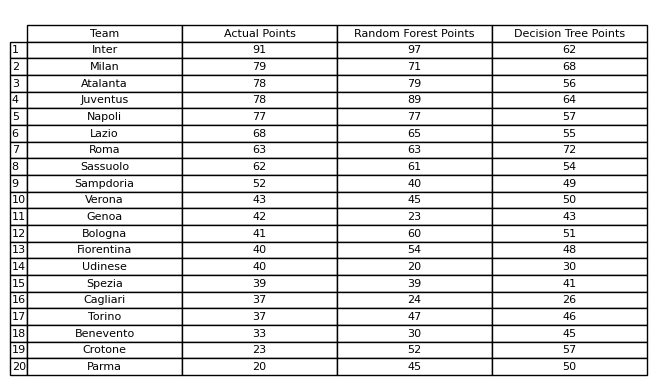

In [44]:
final = pd.merge(actual_points_1, final_table_rf, how='outer',left_on=['Team'], right_on=['Team'])
final = pd.merge(final, final_table_dt, how='outer',left_on=['Team'], right_on=['Team'])
final = final.drop(columns=['Home Points_x', 'Away Points_x','Actual Placement_x', 'Home Points_y', 'Away Points_y' ,'Actual Placement_y', 'Home Points', 'Away Points'])
final = final.rename(columns={'Total Points_x':'Actual Points','Total Points_y':'Random Forest Points', 'Total Points':'Decision Tree Points'})


#Increase index by 1
final.index = final.index +1

#Create figure and axis
fig = plt.figure(figsize = (8, .2))
ax = fig.add_subplot(111)

#Create table for decsisiom tree 
ax.table(cellText = final.values, rowLabels = final.index, 
         colLabels = final.columns, cellLoc='center')



#turn axes off
ax.axis('off')
plt.show()